# HSE 2025: Mathematical Methods for Data Analysis

## Assignment 2: Classification

**Topic:** Binary and Multiclass Text Classification with Logistic Regression and SVM

**Warning 1**: Some tasks (especially hyperparameter tuning and vectorization) require significant computational time, so **start early (!)**

**Warning 2**: It is critical to **describe and explain** what you are doing and why. Use markdown cells to document your observations, findings, and conclusions throughout the assignment.

In [33]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.utils import resample
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

$$\nabla_w L(w) = \nabla_w \left[ \sum_{i=1}^N \left(-y_i \log\sigma(w^\top x_i) - (1 - y_i) \log(1 - \sigma(w^\top x_i))\right) + \gamma \|w\|_1 + \beta \|w\|_2^2 \right] = \\
= \sum_{i=1}^N \nabla_w \left(-y_i \log\sigma(w^\top x_i) - (1 - y_i) \log(1 - \sigma(w^\top x_i))\right) + \nabla_w (\gamma \|w\|_1) + \nabla_w (\beta \|w\|_2^2) = \\
= \sum_{i=1}^N x_i (\sigma(w^\top x_i) - y_i) + \gamma \cdot \text{sign}(w) + 2\beta w = \\
= X^\top (\sigma(Xw) - y) + \gamma \cdot \text{sign}(w) + 2\beta w$$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [34]:
def sigmoid(x):
  return (1.0 / (1 + np.exp(-x)))

In [35]:
def loss(X, y, w: List[float], gamma=1.0, beta=1.0) -> float:
    return  np.dot(-y, np.log(sigmoid(X.dot(w.T)))) - np.dot(1 - y, np.log(1- sigmoid(X.dot(w.T)))) + gamma * np.linalg.norm(w, 1) + beta * np.linalg.norm(w, 2)

#### 3. [0.25 points] Implement the gradient (as a function)

In [36]:
def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
    predictions = sigmoid(X.dot(w))
    grad_w = (X.T).dot((predictions - y)) + gamma * np.sign(w) + 2 * beta * w

    return grad_w

#### Check yourself

In [37]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)
assert np.allclose(
    grad_w, [-3.99447493, -1.84786723, 0.64520104, 1.67059973, -5.03858487, -5.21496336], rtol=1e-2
) # вроде все норм

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [38]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [39]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42, alpha=0.5):
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.w = None
        self.alpha = alpha
        self.loss_history = None

    def fit(self, X, y):
        X = np.c_[np.ones(X.shape[0]), X]
        self._init(size=X.shape[1])
        self.classes_ = np.unique(y)

        last_w = self.w.copy()
        current_iter = 0
        while self._stop_condition(current_iter, last_w):
            current_iter += 1
            last_w = self.w.copy()
            gradient = get_grad(X, y, self.w, gamma=self.gamma, beta=self.beta)
            self.w = self.w - self.learning_rate * gradient
            self.loss_history.append(loss(X, y, self.w, gamma=self.gamma, beta=self.beta))

        return self

    def predict(self, X):
        self._check_trained()
        X = np.c_[np.ones(X.shape[0]), X]
        probabilities = sigmoid(np.dot(X, self.w))
        predictions = (probabilities >= self.alpha).astype(int)

        return np.array([self.classes_[pred] for pred in predictions])

    def predict_proba(self, X):
        self._check_trained()
        X = np.c_[np.ones(X.shape[0]), X]
        prob_positive = sigmoid(np.dot(X, self.w))
        prob_negative = 1 - prob_positive

        return np.column_stack([prob_negative, prob_positive])

    def _init(self, size):
        if self.w is None:
            np.random.seed(self.random_state)
            self.w = np.random.normal(size=size)
        if self.loss_history is None:
            self.loss_history = []

    def _check_trained(self):
        if self.w is None or self.loss_history is None:
            raise Exception("Not trained")

    def _stop_condition(self, current_iter, last_w):
        return current_iter < self.max_iter and np.linalg.norm(self.w - last_w) > self.tolerance or current_iter == 0

In [40]:
# sample data to test your model
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=180,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=42,
    n_clusters_per_class=1,
)

In [41]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200), np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y)

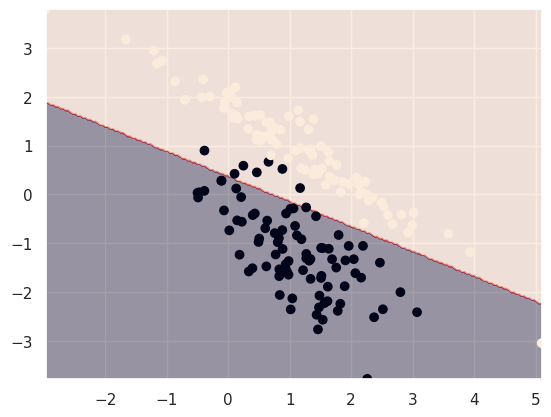

In [42]:
model = Logit(0, 0)
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

In [43]:
def plot_loss_diagram(model):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    lh = model.loss_history
    ax.plot(range(len(lh)), lh, linewidth=2)
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")
    plt.title("Loss Function Convergence")
    plt.grid(True, alpha=0.3)
    plt.show()

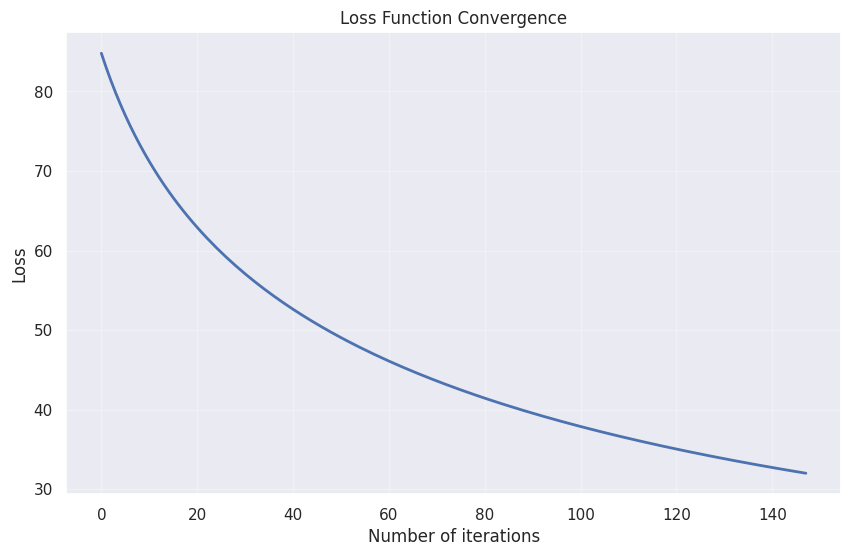

In [44]:
plot_loss_diagram(model)

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [45]:
metrics = ['accuracy', 'roc_auc', 'f1', 'variance']
kernels = ['linear', 'poly', 'rbf']
reg_coefs =  [10 ** e for e in range(-4, 1)]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

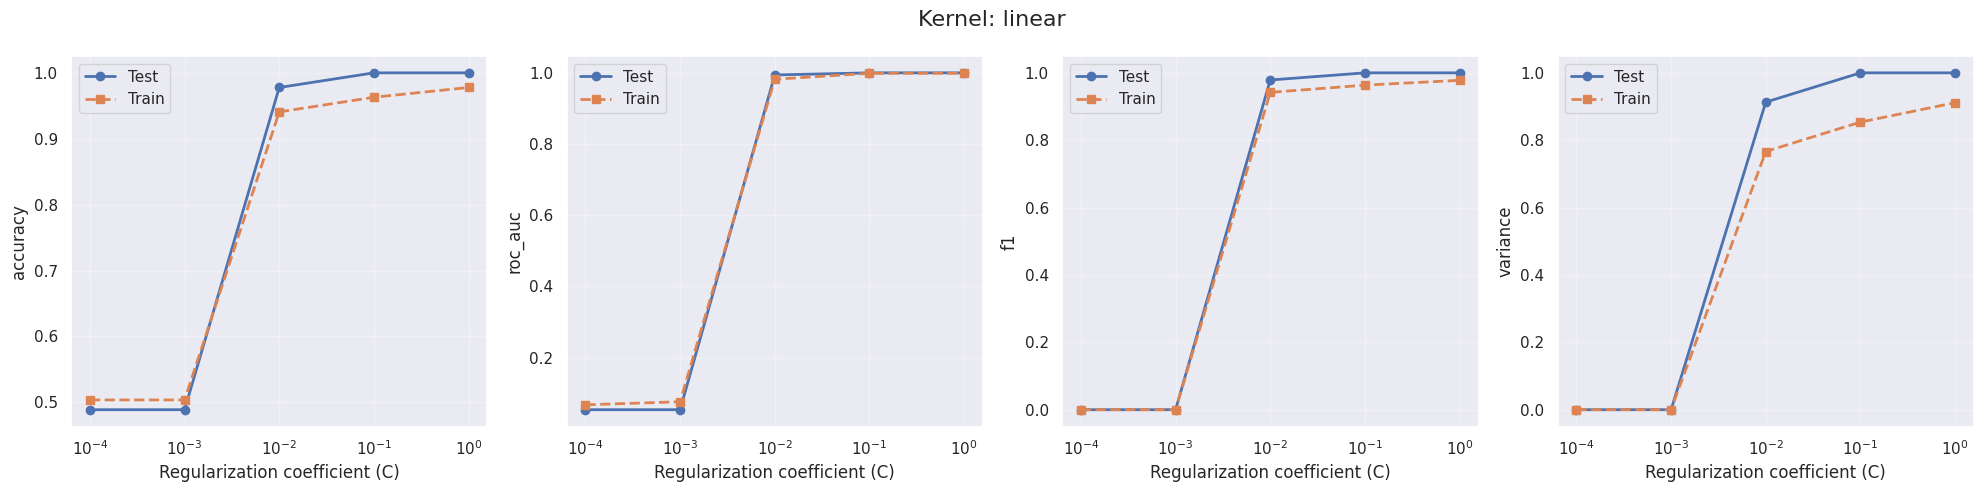

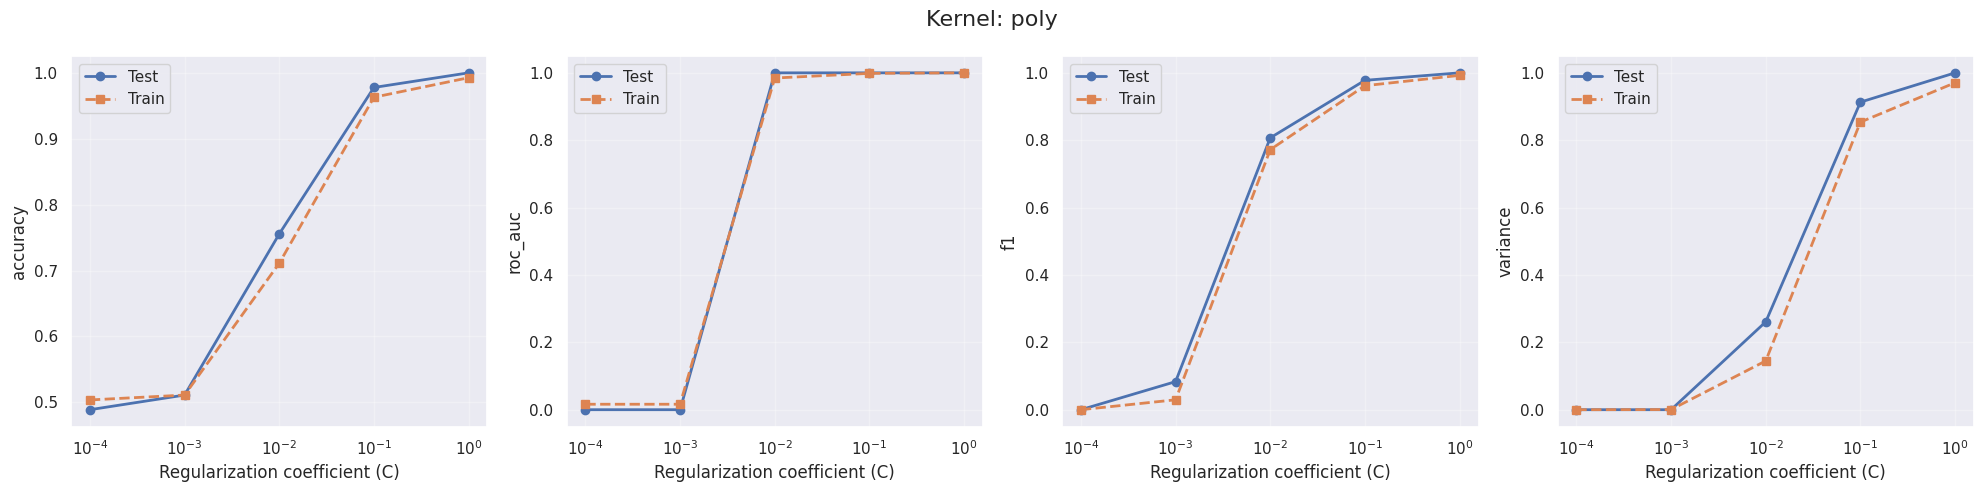

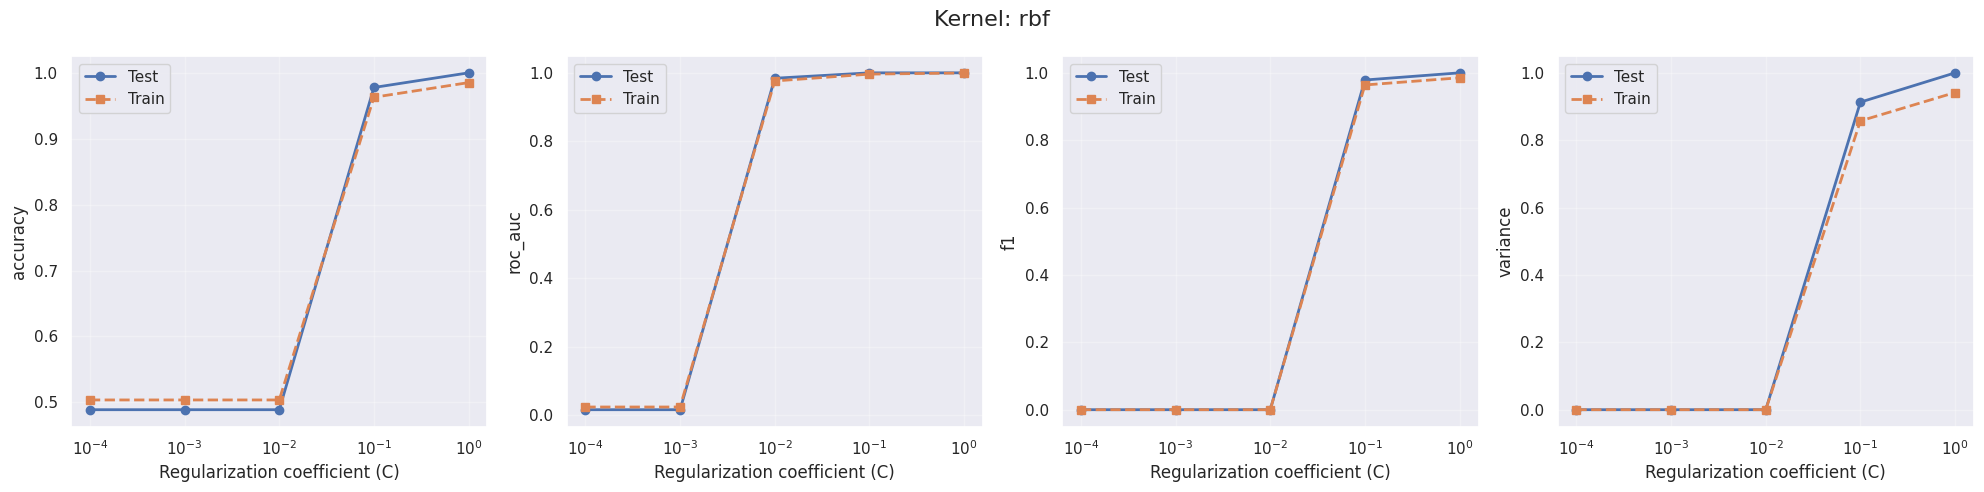

In [46]:
def build_result(kernels, metrics):
    return {m: {k: {'C': []} for k in kernels} for m in metrics}

def fill_result(result, y_true, y_pred, y_pred_proba, kernel, metrics):
    for m in metrics:
        if m == 'accuracy':
            result[m][kernel]['C'].append(accuracy_score(y_true, y_pred))
        elif m == 'f1':
            result[m][kernel]['C'].append(f1_score(y_true, y_pred))
        elif m == 'roc_auc':
            result[m][kernel]['C'].append(roc_auc_score(y_true, y_pred_proba[:, 1]))
        elif m == 'variance':
            result[m][kernel]['C'].append(explained_variance_score(y_true, y_pred))

def process(X_train, X_test, y_train, y_test, kernels, reg_coefs, metrics):
    results = build_result(kernels, metrics)
    trains = build_result(kernels, metrics)

    for k, c in product(kernels, reg_coefs):
        svc = SVC(kernel=k, C=c, probability=True, random_state=42).fit(X_train, y_train)

        y_pred = svc.predict(X_test)
        y_pred_proba = svc.predict_proba(X_test)
        fill_result(results, y_test, y_pred, y_pred_proba, k, metrics)

        y_train_pred = svc.predict(X_train)
        y_train_pred_proba = svc.predict_proba(X_train)
        fill_result(trains, y_train, y_train_pred, y_train_pred_proba, k, metrics)

    return results, trains

def plot_params_affection(results, trains, kernels, reg_coefs, metrics):
    for k in kernels:
        fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))
        fig.suptitle(f'Kernel: {k}', fontsize=16)

        for i, m in enumerate(metrics):
            axes[i].plot(reg_coefs, results[m][k]['C'], 'o-', label='Test', linewidth=2)
            axes[i].plot(reg_coefs, trains[m][k]['C'], 's--', label='Train', linewidth=2)
            axes[i].set_xscale('log')
            axes[i].set_xlabel('Regularization coefficient (C)')
            axes[i].set_ylabel(m)
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

results, trains = process(X_train, X_test, y_train, y_test, kernels, reg_coefs, metrics)
plot_params_affection(results, trains, kernels, reg_coefs, metrics)

#### Ответы на вопросы и выводы:

1. Чувствительность к гиперпараметрам:

linear:
По графику мы видим, что метрики резко улучшаются при увеличении C от очень маленьких значений до примерно 10^-2, после чего стабилизируются. Значит, линейное ядро чувствительно к регуляризации при малых значениях C, но дальше становится стабильным.

poly: Аналогично линейному, метрики растут с увеличением C, но тут рост более плавный, при больших C метрики достигают высоких значений. Получаем, что полиномиальное ядро также чувствительно к C, особенно при малых значениях.

rbf:
Метрики практически равны нулю вплоть до 10^-2, затем резко растут и достигают максимума при 10^-1. Это ядро очень чувствительно к регуляризации, особенно при переходе от очень маленьких к средним значениям C.



2. Чувствительность к регуляризации:

при очень малых значениях C (сильная регуляризация) все ядра показывают плохие результаты, то есть модель недооубучена. С увеличением C (уменьшение регуляризации) качество растёт, достигая максимума. Для линейного и полиномиального ядер после 10^-2 качество стабилизируется, для rbf - 10^-1.


3. Переобучение: для всех ядер видна совсем небольшая разница между обучением и тестом при больших C, но она незначительна. Чуть больше различия у линейного ядра, у которого также видим высокую дисперсия при больших, что
говорит о том, что модель становится более сложной и менее стабильной, чувствительной к изменениям данных и склонной к переобучени.


Вывод: линейное ядро при больших C требует осторожности из-за роста дисперсии, а rbf ядро наиболее чувствительно к выбору C.

## PART 3: Natural Language Processing

#### 7. [1.75 point] Load and preprocess the AG News dataset

We are going to work with the **AG News** dataset for binary and multiclass text classification tasks.

**About the dataset:**
- AG News contains news articles from 4 categories: **World**, **Sports**, **Business**, and **Sci/Tech**
- Each sample consists of a title and description
- The dataset has 120,000 training samples and 7,600 test samples
- It's a classic benchmark for text classification

**Your tasks:**

1. **Load the dataset** (you can use one of these methods):
    * Download from [Kaggle](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset) or [Hugging Face](https://huggingface.co/datasets/fancyzhx/ag_news)
    * Or use the CSV files available online
    * The dataset should have columns: `text` (or title + description combined) and `label` (0-3 for the 4 categories)
    
2. **Data sampling and preparation:**
    * Fix random state (e.g., `random_state=42`)
    * Sample a subset of the data for computational efficiency: **20,000 samples for training** and **3,000 for testing**
    * Ensure class balance is maintained during sampling
    * Combine title and description into a single text field if they're separate
    * Show the distribution of classes in your sample
    
    Sample data structure:
    
    | text | label |
    |------|-------|
    | Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again. | 2 (Business) |
    | Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group... | 2 (Business) |
    | Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries about the economy... | 2 (Business) |
     
3. **Text preprocessing:**
    * Tokenize the text
    * Convert to lower case
    * Remove stop words using `nltk.corpus.stopwords` (English stopwords)
    * Remove punctuation (`string.punctuation`) and numbers
    * Apply either **stemming** (e.g., PorterStemmer) or **lemmatization** (e.g., WordNetLemmatizer) - explain your choice
    * Show examples of preprocessed text vs original text
    
4. **Vectorization:**
    * Vectorize the preprocessed text using both:
        - **Bag of Words (CountVectorizer)** with appropriate parameters (max_features, etc.)
        - **TF-IDF (TfidfVectorizer)** with appropriate parameters
    * Observe and describe the difference between the two vectorization methods:
        - What do the numbers represent in each case?
        - How do the value ranges differ?
        - Which method might be better for this task and why?
    * Show statistics: vocabulary size, sparsity, most frequent words, etc.

In [47]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [48]:
df = pd.read_csv('ag_news.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB
None


,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [49]:
df['text'] = df['Title'] + ' ' + df['Description']

class_names = {
    1: "World",
    2: "Sports",
    3: "Business",
    4: "Sci/Tech"
}

processed_df = pd.DataFrame({
    'text': df['text'],
    'label': df['Class Index'].apply(lambda x: f"{x} ({class_names[x]})")
})


print("Распределение классов:")
label_counts = processed_df['label'].value_counts().sort_index()
print(label_counts)
processed_df.head()

Распределение классов:
label
1 (World)       30000
2 (Sports)      30000
3 (Business)    30000
4 (Sci/Tech)    30000
Name: count, dtype: int64


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,3 (Business)
1,Carlyle Looks Toward Commercial Aerospace (Reu...,3 (Business)
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,3 (Business)
3,Iraq Halts Oil Exports from Main Southern Pipe...,3 (Business)
4,"Oil prices soar to all-time record, posing new...",3 (Business)


In [50]:
df['numeric_label'] = df['Class Index']

train_df, test_df = train_test_split(
    df,
    test_size=3000,
    train_size=20000,
    stratify=df['numeric_label'],
    random_state=42
)

train_final = pd.DataFrame({
    'text': train_df['text'],
    'label': train_df['Class Index'].apply(lambda x: f"{x} ({class_names[x]})")
})

test_final = pd.DataFrame({
    'text': test_df['text'],
    'label': test_df['Class Index'].apply(lambda x: f"{x} ({class_names[x]})")
})

print(f"Тренировочные данные: {len(train_final)} samples")
print(f"Тестовые данные: {len(test_final)} samples")

print("Распределение классов в тренировочных данных:")
train_label_counts = train_final['label'].value_counts().sort_index()
for label, count in train_label_counts.items():
    print(f"  {label} - {count} samples")

print("Распределение классов в тестовых данных:")
test_label_counts = test_final['label'].value_counts().sort_index()
for label, count in test_label_counts.items():
    print(f"  {label} - {count} samples")

Тренировочные данные: 20000 samples
Тестовые данные: 3000 samples
Распределение классов в тренировочных данных:
  1 (World) - 5000 samples
  2 (Sports) - 5000 samples
  3 (Business) - 5000 samples
  4 (Sci/Tech) - 5000 samples
Распределение классов в тестовых данных:
  1 (World) - 750 samples
  2 (Sports) - 750 samples
  3 (Business) - 750 samples
  4 (Sci/Tech) - 750 samples


In [51]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text): # предобработка текста согласно условию
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # лемматизация лучше, так как сохраняет смысл, что важно для новостей, тем в более на английском языке,
    # где важно сохранить контескт, так как слова имеют множество значений в базовой форме
    return ' '.join(tokens)

train_final['processed_text'] = train_final['text'].apply(preprocess_text)
test_final['processed_text'] = test_final['text'].apply(preprocess_text)

# примеры до и после обработки
for i in range(3):
    original = train_final.iloc[i]['text']
    processed = train_final.iloc[i]['processed_text']
    label = train_final.iloc[i]['label']

    print(f"Пример {i+1} (Класс: {label}):")
    print(f"до: {original}")
    print(f"после: {processed}")

Пример 1 (Класс: 2 (Sports)):
до: BASEBALL: JETS ARE FLYING THIS weekend sees the  quot;other quot; showdown between New York and New England as the Jets and Patriots clash in a battle of the unbeaten teams.
после: baseball jet flying weekend see quot quot showdown new york new england jet patriot clash battle unbeaten team
Пример 2 (Класс: 2 (Sports)):
до: Williams to meet Klitschko for title British heavyweight Danny Williams , who knocked out Mike Tyson in the fourth round July 30, will meet Vitali Klitschko Dec. 11 at the Mandalay Bay hotel-casino in Las Vegas for the World Boxing Council version of the heavyweight title . . . Willie Randolph interviewed for the Mets' managerial job, and stressed that his many years with the Yankees ...
после: williams meet klitschko title british heavyweight danny williams knocked mike tyson fourth round july meet vitali klitschko dec mandalay bay hotel casino la vega world boxing council version heavyweight title willie randolph interviewed mets 

In [52]:
vectorizer_params = {
    'max_features': 5000,
    'min_df': 5, # мин кол-во раз встречаемость
    'max_df': 0.7, # слова встречаемые часто в документах
    'ngram_range': (1, 2),
    'stop_words': 'english'
}

In [53]:
print("Bag of Words")
bow_vectorizer = CountVectorizer(**vectorizer_params)
X_train_bow = bow_vectorizer.fit_transform(train_final['processed_text'])
X_test_bow = bow_vectorizer.transform(test_final['processed_text'])

bow_features = bow_vectorizer.get_feature_names_out()
bow_frequencies = np.asarray(X_train_bow.sum(axis=0)).flatten()

print(f"Размер словаря: {len(bow_features)}")
print(f"Размерность train: {X_train_bow.shape}")
print(f"Размерность test: {X_test_bow.shape}")
print(f"Разреженность: {1 - (X_train_bow.nnz / (X_train_bow.shape[0] * X_train_bow.shape[1])):.3f}")

# топ-10 слов
top_bow_indices = bow_frequencies.argsort()[-10:][::-1]
print("Топ-10 слов (BoW):")
for idx in top_bow_indices:
    print(f"  {bow_features[idx]}: {int(bow_frequencies[idx])}")

Bag of Words
Размер словаря: 5000
Размерность train: (20000, 5000)
Размерность test: (3000, 5000)
Разреженность: 0.996
Топ-10 слов (BoW):
  new: 3616
  said: 3402
  reuters: 3154
  year: 2394
  company: 1686
  quot: 1577
  world: 1419
  game: 1322
  monday: 1283
  wednesday: 1276


In [54]:
print("TF-IDF")
tfidf_vectorizer = TfidfVectorizer(**vectorizer_params)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_final['processed_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_final['processed_text'])

tfidf_features = tfidf_vectorizer.get_feature_names_out()
tfidf_idf_scores = tfidf_vectorizer.idf_

print(f"Размер словаря: {len(tfidf_features)}")
print(f"Размерность train: {X_train_tfidf.shape}")
print(f"Размерность test: {X_test_tfidf.shape}")
print(f"Разреженность: {1 - (X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])):.3f}")

# топ-10 слов TF-IDF (по IDF)
top_tfidf_indices = tfidf_idf_scores.argsort()[:10]
print("Топ-10 частых слов (TF-IDF):")
for idx in top_tfidf_indices:
    print(f"  {tfidf_features[idx]}: {tfidf_idf_scores[idx]:.3f}")

TF-IDF
Размер словаря: 5000
Размерность train: (20000, 5000)
Размерность test: (3000, 5000)
Разреженность: 0.996
Топ-10 частых слов (TF-IDF):
  said: 2.799
  new: 2.898
  reuters: 3.245
  year: 3.246
  company: 3.569
  wednesday: 3.758
  monday: 3.759
  world: 3.784
  tuesday: 3.789
  say: 3.807


Ответы на вопросы:

Значения цифр:

BoW: Цифра показывает абсолютную частоту слова в документе (сколько раз оно встретилось).

TF-IDF: Цифра отражает взвешенную важность слова, учитывая как его частоту в документе, так и редкость во всей коллекции.

Поэтому диапазоны значений:

BoW: Только целые неотрицательные числа

TF-IDF: Вещественные неотрицательные числа

Я думаю, что для задачи с новостями лучше TF-IDF, так как новости часто содержат много общих слов. Этот метод снижает вес таких частых, но маловажных слов и повышает значимость уникальных слов, которые действительно важны, что улучшает различение категорий.

In [55]:
y_train = train_df['Class Index']
y_test = test_df['Class Index']

print(f"X_train_bow: {X_train_bow.shape}, X_train_tfidf: {X_train_tfidf.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train_bow: (20000, 5000), X_train_tfidf: (20000, 5000)
y_train: (20000,), y_test: (3000,)


###  Binary classification

#### 8. [2 point] Train models using Logistic Regression (your own) and SVC (SVM from sklearn)

For this task, perform binary classification on a subset of the AG News dataset:

* **Choose two categories** from the AG News dataset (e.g., Sports vs Business, or World vs Sci/Tech)
* **Check the balance of classes** - visualize the distribution and comment on whether classes are balanced
* **Split the data**: divide into train and test samples with **0.7/0.3 split** (fix random_state for reproducibility)
* **Try both vectorization methods**: compare the performance with Bag of Words and TF-IDF
* **Hyperparameter tuning**:
    - Use **GridSearchCV** to find the best parameters for both models (optimize by **F1 score**)
    - For Logistic Regression (your implementation from Task 4): tune `gamma`, `beta`, `learning_rate`
    - For SVC: tune `C`, `kernel`, and kernel-specific parameters (e.g., `gamma` for RBF)
* **Visualizations**:
    - Plot the dependence of F1 score on different parameters (2-3 plots minimum)
    - Plot **confusion matrices** for both train and test samples (for both models)
* **Evaluation metrics**: compute and report for the test set:
    - Accuracy, Precision, Recall, F1-score
    - ROC AUC score
* **Conclusions**:
    - Which model performs better?
    - How does vectorization method affect performance?
    - Are there signs of overfitting/underfitting?
    - Which categories are easier/harder to distinguish?


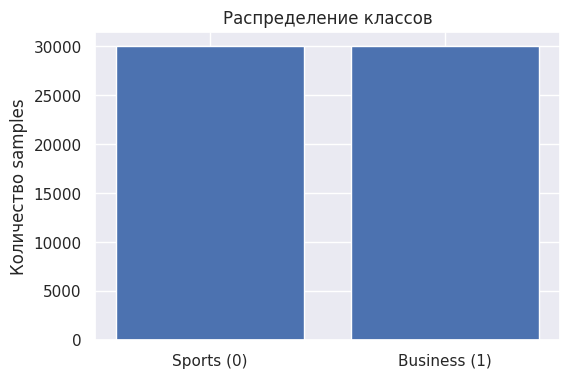

In [56]:
binary_data = df[df['Class Index'].isin([2, 3])].copy()  # бинарный набор данных
binary_data['binary_label'] = binary_data['Class Index'].apply(lambda x: 0 if x == 2 else 1)

plt.figure(figsize=(6, 4))
class_counts = binary_data['binary_label'].value_counts()
plt.bar(['Sports (0)', 'Business (1)'], class_counts.values)
plt.title('Распределение классов')
plt.ylabel('Количество samples')
plt.show()

In [57]:
binary_data['processed_text'] = binary_data['text'].apply(preprocess_text)

X_text_train, X_text_test, y_train, y_test = train_test_split(
    binary_data['processed_text'],
    binary_data['binary_label'],
    test_size=0.3,
    random_state=42,
    stratify=binary_data['binary_label']
)

print(f"Train: {len(X_text_train)} samples") # 70/30
print(f"Test: {len(X_text_test)} samples")
print(f"Распределение в train: Sports {(y_train == 0).sum()}, Business {(y_train == 1).sum()}")

Train: 42000 samples
Test: 18000 samples
Распределение в train: Sports 21000, Business 21000


In [58]:
vectorizer_params = {
    'max_features': 5000,
    'min_df': 5,
    'max_df': 0.7,
    'ngram_range': (1, 2),
    'stop_words': 'english'
}

# TF-IDF векторизация:
tfidf_vectorizer_binary = TfidfVectorizer(**vectorizer_params)
X_train_tfidf = tfidf_vectorizer_binary.fit_transform(X_text_train)
X_test_tfidf = tfidf_vectorizer_binary.transform(X_text_test)

print(f"Размеры данных:")
print(f"X_train_tfidf: {X_train_tfidf.shape}")
print(f"X_test_tfidf: {X_test_tfidf.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

# dense матрицы для Logistic Regression
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

Размеры данных:
X_train_tfidf: (42000, 5000)
X_test_tfidf: (18000, 5000)
y_train: (42000,), y_test: (18000,)


In [60]:
!pip install scikit-learn-intelex

from sklearnex import patch_sklearn
patch_sklearn()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.3/111.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 44.2 MB/s eta 0:00:00


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [62]:
# подбор гиперпараметров для Logistic Regression с TF-IDF
logit_param_grid = {
    'beta': [0.1, 1.0, 10.0],
    'gamma': [0.1, 1.0, 10.0],
    'learning_rate': [0.01, 0.1, 0.5]
}

def custom_logit_grid_search(X_train, X_test, y_train, y_test, param_grid):
    best_score = 0
    best_params = {}
    results = []

    for beta in param_grid['beta']:
        for gamma in param_grid['gamma']:
            for lr in param_grid['learning_rate']:
                model = Logit(beta=beta, gamma=gamma, lr=lr, max_iter=1000, random_state=42)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                f1 = f1_score(y_test, y_pred)

                results.append({
                    'beta': beta,
                    'gamma': gamma,
                    'learning_rate': lr,
                    'f1_score': f1
                })

                if f1 > best_score:
                    best_score = f1
                    best_params = {'beta': beta, 'gamma': gamma, 'learning_rate': lr}

    print(f"Лучшие параметры: {best_params}")
    print(f"Лучший F1: {best_score:.4f}")

    return best_params, best_score, results

best_logit, score_logit, results_logit = custom_logit_grid_search(
    X_train_tfidf_dense, X_test_tfidf_dense, y_train, y_test, logit_param_grid
)

# подбор гиперпараметров для SVC с TF-IDF
svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc_grid = GridSearchCV(
    SVC(random_state=42, probability=True),
    svc_param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
svc_grid.fit(X_train_tfidf, y_train)
print(f"лучшие параметры: {svc_grid.best_params_}")
print(f"лучший F1: {svc_grid.best_score_:.4f}")

/tmp/ipython-input-4155957504.py:2: RuntimeWarning: divide by zero encountered in log
  return  np.dot(-y, np.log(sigmoid(X.dot(w.T)))) - np.dot(1 - y, np.log(1- sigmoid(X.dot(w.T)))) + gamma * np.linalg.norm(w, 1) + beta * np.linalg.norm(w, 2)
/tmp/ipython-input-4155957504.py:2: RuntimeWarning: divide by zero encountered in log
  return  np.dot(-y, np.log(sigmoid(X.dot(w.T)))) - np.dot(1 - y, np.log(1- sigmoid(X.dot(w.T)))) + gamma * np.linalg.norm(w, 1) + beta * np.linalg.norm(w, 2)


KeyboardInterrupt: 

Тут у меня больше часа грузится код подбора параметров (ожидаемо, но уже не успеваю доделать...)

жаль.

#### 9. [1 point] Analyzing ROC AUC and threshold selection

It is possible to control the proportion of statistical errors of different types by adjusting the classification threshold.

**Your tasks:**

* **Plot ROC curves** for both Logistic Regression and SVC models (use the same 2 categories from Task 8)
* **Show threshold values** on the ROC curve plots (mark several key thresholds: 0.3, 0.5, 0.7, etc.)
* **Threshold analysis**:
    - Choose a threshold such that your models have **no more than 30% False Positive Rate (FPR)**
    - Report the corresponding True Positive Rate (TPR) for this threshold
    - Visualize this operating point on the ROC curve
* **Compare models**: which model achieves better TPR at the same FPR constraint?
* **Interpret results**: explain the trade-off between FPR and TPR for your chosen threshold

**Hint:** Pay attention to the `thresholds` parameter returned by `sklearn.metrics.roc_curve`

In [ ]:
# сегодня без рок кривой

### Multiclass logit

#### 10. [1 point] Multiclass classification using One-vs-One strategy

Apply the [OneVsOneClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html) wrapper to your Logit model (from Task 4) to create a multiclass classifier.

**Note:** You can use sklearn's LogisticRegression instead of your own implementation, but with a **penalty of 0.5 points**

**Your tasks:**

* **Use all 4 categories** from the AG News dataset (World, Sports, Business, Sci/Tech)
* **Split the data**: divide into train and test samples with **0.7/0.3 split** (fix random_state)
* **Hyperparameter tuning**: use **GridSearchCV** to find the best parameters optimized by **macro-averaged F1 score**
    - For your Logit: tune `gamma`, `beta`, `learning_rate`
    - Consider both BoW and TF-IDF vectorizations
* **Visualizations**:
    - Plot **confusion matrix** for both train and test samples
    - Visualize per-class performance (bar plot with precision, recall, F1 for each category)
* **Evaluation metrics** (use sklearn, compute for test set):
    - Overall accuracy
    - Macro-averaged and weighted-averaged: Precision, Recall, F1-score
    - Per-class metrics (classification report)
* **Analysis**:
    - Which categories are most often confused with each other?
    - Are some categories easier to classify than others?
    - How many binary classifiers were trained in the One-vs-One approach?
    - Compare performance with potential One-vs-Rest approach (theoretical discussion)

In [ ]:
# тоже мимо